# Champagne sales forecasting

### Importing libraries

In [453]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.multioutput import RegressorChain

from xgboost import XGBRegressor

In [454]:
# defining plot params
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

### Importing data

In [455]:
df_sales = pd.read_csv("Data/Sales.csv")

df_sales.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Here we have a time series with Date and Sales features

### Converting Dates into datetime format

We need to convert each date into datetime format (for future simplicity)

In [456]:
df_sales.Month = pd.to_datetime(df_sales.Month, format="%Y-%m")

In [457]:
# Rename "Month" feature into "Date"
df_sales.rename(
    columns={
        "Month": "Date"
    },
    inplace=True
)

In [458]:
df_sales.Date.head()

0   1964-01-01
1   1964-02-01
2   1964-03-01
3   1964-04-01
4   1964-05-01
Name: Date, dtype: datetime64[ns]

### Plotting a Time Series

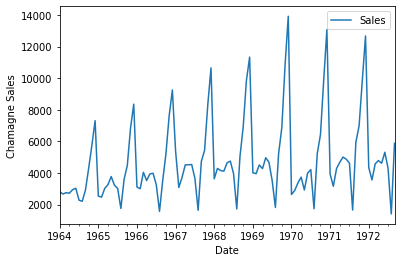

In [459]:
# Plotting Sales by Date
df_sales.plot.line(x="Date", y="Sales")

plt.ylabel("Chamagne Sales")
plt.show()

Here we can see some annual seasonality and probably a trend

### Testing for Stationarity

We need to check if our Time Series is stationary or not, because many useful analytical tools and statistical tests and models rely on it

In [460]:
from statsmodels.tsa.stattools import adfuller

In [461]:
test_result=(df_sales["Sales"])

In [462]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [463]:
adfuller_test(df_sales["Sales"])

ADF Test Statistic : -1.8335930563276193
p-value : 0.36391577166024686
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Time Series trend

Here we explore trend in a given Time Series

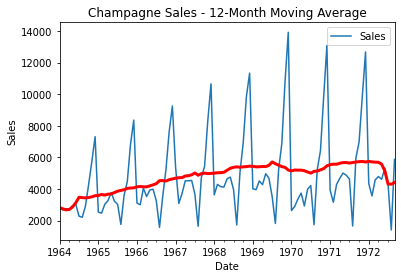

In [464]:
# Creating Moving Average with 12 month window
moving_average = df_sales.set_index("Date").rolling(
    window=12,
    center=True,
    min_periods=6
).mean()

ax = df_sales.plot.line(x="Date", y="Sales")
moving_average.plot(
    ax=ax, linewidth=3, title="Champagne Sales - 12-Month Moving Average",
    legend=False, color='red'
)

plt.ylabel("Sales")
plt.show()

Time Series definitely has a trend and it seems to be qubic

### Predicting Trend using Deterministic Process

Now I will try to predict a future trend by using Linear Regression

In [465]:
dp = DeterministicProcess(
    index=df_sales.Date, # dates from the training data
    constant=True, # dummy feature for the bias (y_intercept)
    order=3, # the time dummy (trend) - qubic in our case
    drop=True # drop terms if necessary to avoid collinearity
)

# `in_sample` creates features for the dates given in the `index` argument
X=dp.in_sample()

X.head()

,const,trend,trend_squared,trend_cubed
Date,,,,
1964-01-01,1.0,1.0,1.0,1.0
1964-02-01,1.0,2.0,4.0,8.0
1964-03-01,1.0,3.0,9.0,27.0
1964-04-01,1.0,4.0,16.0,64.0
1964-05-01,1.0,5.0,25.0,125.0


In [466]:
y = df_sales['Sales']

model = LinearRegression(fit_intercept=False)
# Fit linear regression
model.fit(X, y)

# Make predictions on the training data
y_pred = pd.Series(model.predict(X), index=X.index)

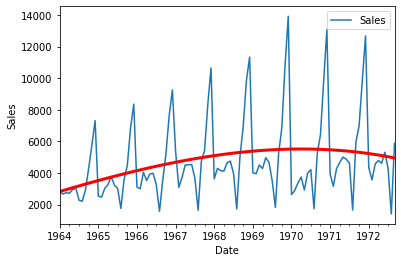

In [467]:
# Plotting predictions
ax = df_sales.plot.line(x="Date", y="Sales")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='red')

plt.ylabel("Sales")
plt.show()

In [468]:
from pandas.tseries.offsets import DateOffset

# Create future Dates for forecasting
future_dates = [dp.index[-1] + DateOffset(months=x) for x in range(1,13)]

In [469]:
# Making a forecast

X = dp.out_of_sample(steps=12)
y_fore = pd.Series(model.predict(X), index=future_dates)

y_fore.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


1972-10-01    4910.845342
1972-11-01    4867.560946
1972-12-01    4822.666897
1973-01-01    4776.151458
1973-02-01    4728.002893
dtype: float64

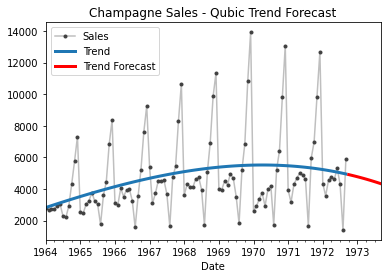

In [470]:
# Plotting results of a forecast

ax = df_sales.plot.line(x="Date", y="Sales", title="Champagne Sales - Qubic Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="red")
_ = ax.legend()

plt.show()

### Time Series Seasonality

Now it's time to explore seasonality in a given Time Series

#### Plotting a Time Series Month-wise in 1964-1965

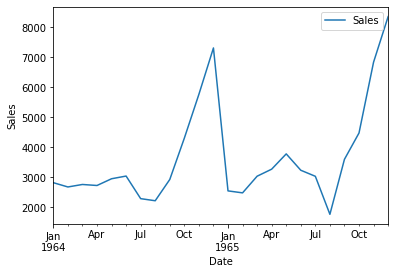

In [471]:
df_sales.iloc[:24, :].plot.line(x="Date", y="Sales")

plt.ylabel("Sales")
plt.show()

Champagne sales rocket from september to december (probably because of Christmas holidays) and then fall off. So there is a clear annual seasonality.

### Making Seasonal Forecast

Let's use Linear Regression in order to make a forecast by using trend and seasonality

In [472]:
dp = DeterministicProcess(
    index=df_sales.Date,
    constant=True,
    order=3,
    period=12,
    seasonal=True,
    drop=True
)

X = dp.in_sample()

In [473]:
# Target Feature
y = df_sales.Sales

# Linear Regression model
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

# Prediction on Training Data
y_pred = pd.Series(model.predict(X), index=df_sales.Date)

# Future forecast for 12 months
X_fore = dp.out_of_sample(steps=12)
y_fore = pd.Series(model.predict(X_fore), index=future_dates)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:435: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


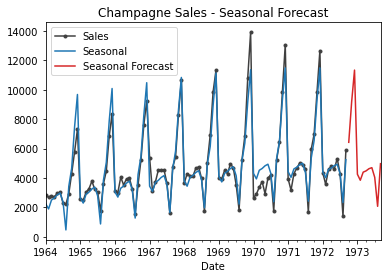

In [474]:
# Plotting results

ax = df_sales.plot(x="Date", y="Sales", color='0.25', style='.-', title="Champagne Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()


plt.show()

It did a good job in fitting training data and a future forecast seems reasonable

## Forecasting

Now let's make a forecast by using different approaches: <br> 1) By using Classical TS model (in our case it's SARIMA, because our TS has a seasonality pattern) <br> 2) By using ML model, in our case it's XGB regressor

### 1-st Approach: Classical TS model (SARIMA)

Firstly we need to make our data stationary

In [475]:
# Differencing by 12 moths

df_sales["Seasonal_Difference"] = df_sales["Sales"] - df_sales["Sales"].shift(12)

In [476]:
df_sales.head(15)

,Date,Sales,Seasonal_Difference
0,1964-01-01,2815,NaN
1,1964-02-01,2672,NaN
2,1964-03-01,2755,NaN
3,1964-04-01,2721,NaN
4,1964-05-01,2946,NaN
5,1964-06-01,3036,NaN
6,1964-07-01,2282,NaN
7,1964-08-01,2212,NaN
8,1964-09-01,2922,NaN
9,1964-10-01,4301,NaN


In [477]:
adfuller_test(df_sales["Seasonal_Difference"].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


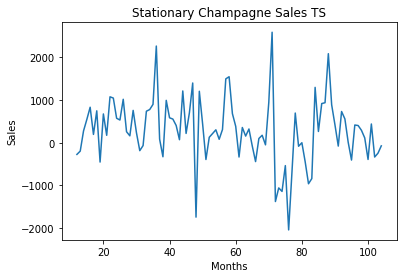

In [478]:
df_sales.Seasonal_Difference.plot(title="Stationary Champagne Sales TS")

plt.xlabel("Months")
plt.ylabel("Sales")
plt.show()

### SARIMA Model

For SARIMA Model we need to choose parameters p, d, q, s. For that we need to use ACF and PACF plots

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


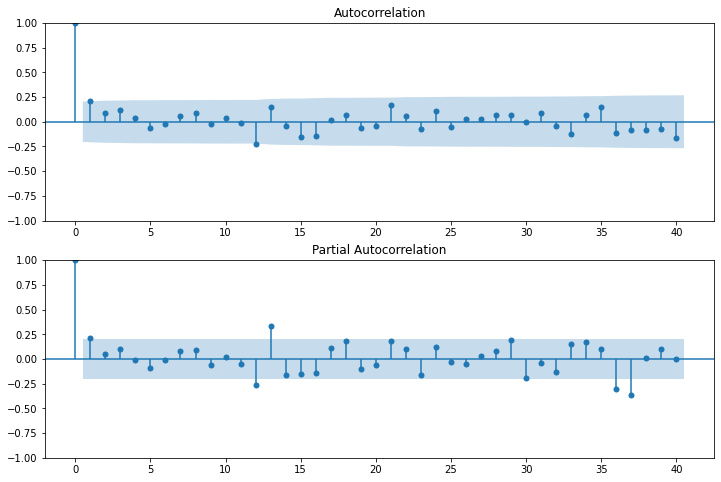

In [479]:
# Plotting ACF and PACF plots

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_sales['Seasonal_Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_sales['Seasonal_Difference'].iloc[13:],lags=40,ax=ax2)

plt.show()

After looking at plots, we conclude: q = 1, d = 1, q = 1, s = 12

In [480]:
# Initializing SARIMA model
model = sm.tsa.statespace.SARIMAX(
    df_sales["Sales"],
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

# Fitting model
model_fit = model.fit()
model_fit.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07295D+00    |proj g|=  4.80911D-02

At iterate    5    f=  7.04942D+00    |proj g|=  1.53381D-02

At iterate   10    f=  7.04713D+00    |proj g|=  2.99455D-04


 This problem is unconstrained.



At iterate   15    f=  7.04708D+00    |proj g|=  5.05918D-03

At iterate   20    f=  7.04413D+00    |proj g|=  1.18430D-02

At iterate   25    f=  7.03252D+00    |proj g|=  1.06079D-03

At iterate   30    f=  7.03240D+00    |proj g|=  5.86754D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     34      1     0     0   1.509D-05   7.032D+00
  F =   7.0324006467401929     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Fri, 07 Oct 2022   AIC                           1486.804
Time:                                    10:45:22   BIC                           1499.413
Sample:                                         0   HQIC                          1491.893
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

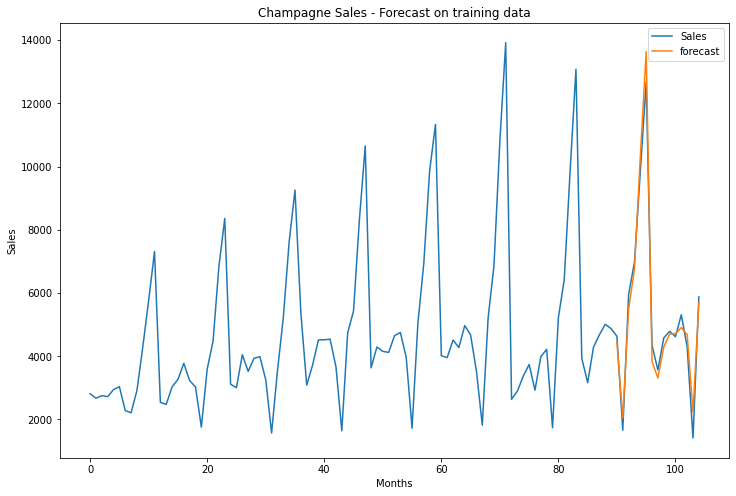

In [481]:
# Making forecast on training data
df_sales['forecast'] = model_fit.predict(start=90, end=105, dynamic=True)

# Plotting results
df_sales[['Sales','forecast']].plot(figsize=(12,8))

plt.xlabel("Months")
plt.ylabel("Sales")
plt.title("Champagne Sales - Forecast on training data")

plt.show()

Model did a good job in fitting a training Data

In [482]:
# Creating future dates for 24 months forecast
future_dates = [dp.index[-1] + DateOffset(months=x) for x in range(0,24)]

In [483]:
df_future = pd.DataFrame(
    index=future_dates[1:],
    columns=df_sales.loc[:, df_sales.columns!="Date"].columns
)

In [484]:
df_future = pd.concat([df_sales.set_index("Date"), df_future])
df_future.reset_index(inplace=True)
df_future = df_future.rename(columns={
    "index": "Date"
})

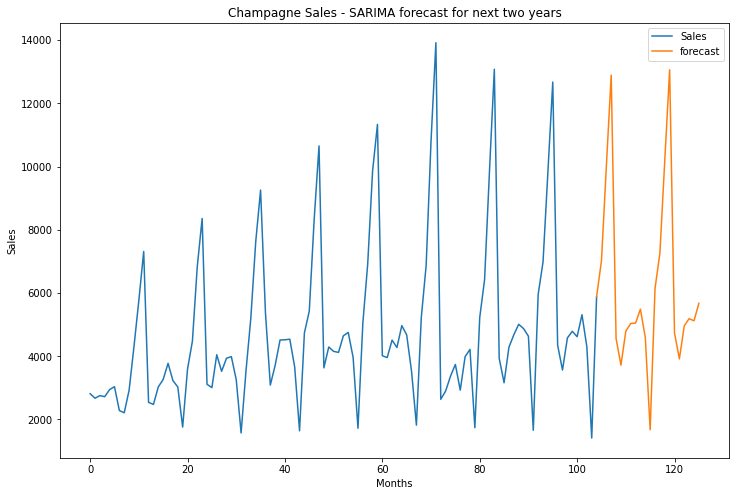

In [485]:
df_future['forecast'] = model_fit.predict(start=104, end=125, dynamic=True)
df_future[['Sales', 'forecast']].plot(figsize=(12, 8))

plt.title("Champagne Sales - SARIMA forecast for next two years")
plt.xlabel("Months")
plt.ylabel("Sales")

plt.show()

The forecast seems reasonable, even though it doesn't follow previously predicted trend

## 2-nd approach: Machine Learning Model with DIREC strategy

Firstly we need to create a helper functions

In [486]:
# Create lag features
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

# Create n-step forecast horizon
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

# Plot multistep forecast
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)

    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))

    for date, preds in y[::every].iterrows():
        preds.index = np.arange(date, date + len(preds))
        preds.plot(ax=ax)
    return ax

Creating Features

In [487]:
# 12 months of lag features
y = df_sales.Sales.copy()
X = make_lags(y, lags=12).fillna(0.0)

# 12-month forecast
y = make_multistep_target(y, steps=12).dropna()

y, X = y.align(X, join='inner', axis=0)

In [488]:
# Create splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = RegressorChain(base_estimator=XGBRegressor())
model.fit(X_train, y_train)

# Making forecast
y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 0.00
Test RMSE: 1019.00


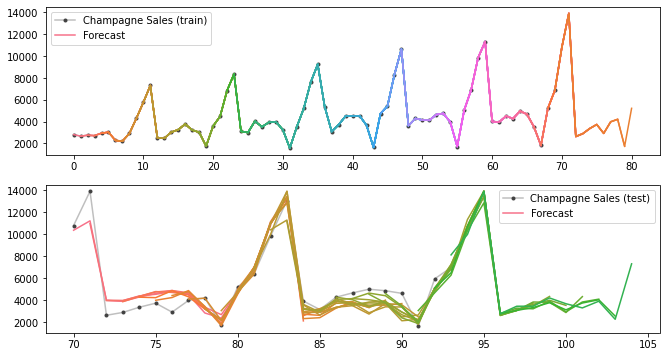

In [489]:
# Train and Test errors
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

# Plotting results
palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))

ax1 = df_sales.Sales[:len(y_fit.index)].plot(x=df_sales.Date[:len(y_fit.index)], **plot_params, ax=ax1)

ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['Champagne Sales (train)', 'Forecast'])
ax2 = df_sales.Sales[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['Champagne Sales (test)', 'Forecast'])

Here we can see an overfitting problem: our model did a great job in fitting training data, but showed a much worse results on a test data. Despite that, this forecast also seems quite reasonable

## Results: